In [1]:
import unittest
import numpy as np
import QuTFyP
import tensorflow as tf
import math

# Demonstration of decay calculation with three methods: Master equation, photon-counting detection stochastic Schrödinger equation

System parameters: 

qubit frequency: 6.0$\mathrm{ GHz}$

initial state: $|1\rangle$
    
decay channel "qubit_decay":
    
rate: 2.0$\mathrm{ns}^{-1}$
    

In [2]:
qed = QuTFyP.TransmonQED()
qed.d = [2] # one degree of freedom with two levels: a qubit
qed.rdtype_np = np.float32
qed.cdtype_np = np.complex64
qed.rdtype = tf.float32
qed.cdtype = tf.complex64
qed.ntraj = 5000
qed.anharmonicities = [0.0] #  anharmonicity is irrelevant for two-level systems
qed.frequencies = [6.0] # in GHz. Transmon is 6.0, resonator is 9.5.
qed.couplings = [] # coupling constants between different degrees of freedom
qed.initialize_operators()
qed.controls = {}
qed.minibatch = 100 # number of time steps with a single noise sample and without resampling
qed.simulation_time = 2.0
qed.dt = 0.001
rwa = False
qed.decoherences = {'qubit_decay':{'measurement_type':'photon-counting',
                          'coupling_type':'a',
                          'rate':4.0,
                          'subsystem_id':0,
                          'record':True,
                          'unmix':True,
                          'unmix_reference':6. if rwa else 0.,
                          'sample_rate':200.,
                          'noise_spectral_density': np.ones((1,), dtype=qed.rdtype_np)}}

gi = [[1,i] for i in range(qed.ntraj)]  # A list of coordinates to update.
gv = [1.0]*qed.ntraj  # A list of values corresponding to the respective
        # coordinate in indices.
qed.set_initial_pure_state(gi, gv)

We watch the system state using observable expectations

In [3]:
qed.expectations = { 'qubit_x': {'unmix':True,
                          'unmix_reference':6. if rwa else 0., 
                          'sample_rate':200.,
            'observable_vec': lambda x,t: tf.real(qed.am_td_expect(x,t,ax=0)),
            'observable_mat': lambda x,t: qed.observable(tf.real(qed.am_d2(x, ax=0)), mode='mat') },
                          'qubit_y': {'unmix':True,
                          'unmix_reference':6. if rwa else 0., 
                          'sample_rate':200.,
            'observable_vec': lambda x,t: tf.imag(qed.am_td_expect(x,t,ax=0)),
            'observable_mat': lambda x,t: qed.observable(tf.imag(qed.am_d2(x, ax=0)), mode='mat') },
                          'qubit_z': {'unmix':True,
                          'unmix_reference':0., 
                          'sample_rate':200.,
            'observable_vec': lambda x,t: qed.observable(tf.real(tf.conj(x)*x*qed.multipliers_sqr_real[0])),
            'observable_mat': lambda x,t: qed.observable(tf.real(qed.multipliers_sqr_real[0]*x), mode='mat') }}

Run simulation

In [4]:
expectations_vec, measurements_vec = qed.run('vec') # photon-counting
expectations_mat = qed.run('mat_pure') # master equation solution
qed.decoherences['qubit_decay']['measurement_type'] = 'homodyne' # switch to homodyne detection
expectations_vec_homodyne, measurements_vec_homodyne = qed.run('vec') # run homodyne solution

homodyne
homodyne
homodyne
homodyne


Single-qubit trajectories

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


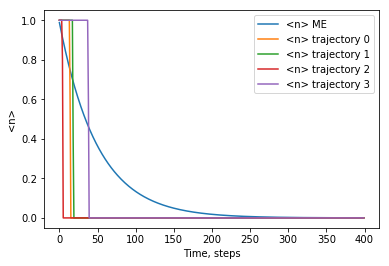

In [5]:
import matplotlib.pyplot as plt
import qutip
%matplotlib inline
plt.plot(np.mean(expectations_mat['qubit_z'], axis=1), label='<n> ME')
plt.plot(expectations_vec['qubit_z'][:,0], label='<n> trajectory 0')
plt.plot(expectations_vec['qubit_z'][:,1], label='<n> trajectory 1')
plt.plot(expectations_vec['qubit_z'][:,2], label='<n> trajectory 2')
plt.plot(expectations_vec['qubit_z'][:,3], label='<n> trajectory 3')
plt.legend()
plt.xlabel('Time, steps')
plt.ylabel('<n>')
plt.savefig('Decay demonstration single-photon.png')
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


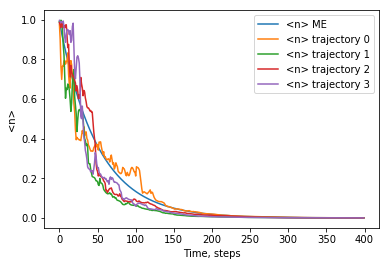

In [6]:
import matplotlib.pyplot as plt
import qutip
%matplotlib inline
plt.plot(np.mean(expectations_mat['qubit_z'], axis=1), label='<n> ME')
plt.plot(expectations_vec_homodyne['qubit_z'][:,0], label='<n> trajectory 0')
plt.plot(expectations_vec_homodyne['qubit_z'][:,1], label='<n> trajectory 1')
plt.plot(expectations_vec_homodyne['qubit_z'][:,2], label='<n> trajectory 2')
plt.plot(expectations_vec_homodyne['qubit_z'][:,3], label='<n> trajectory 3')
plt.legend()
plt.xlabel('Time, steps')
plt.ylabel('<n>')

plt.savefig('Decay demonstration homodyne.png')
plt.show()

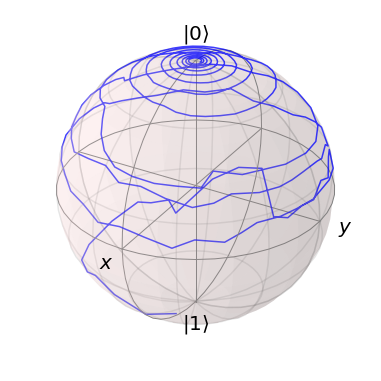

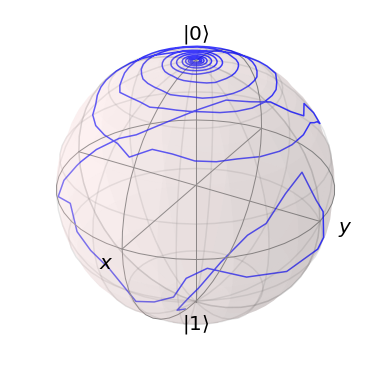

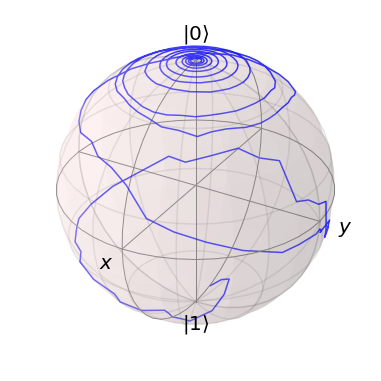

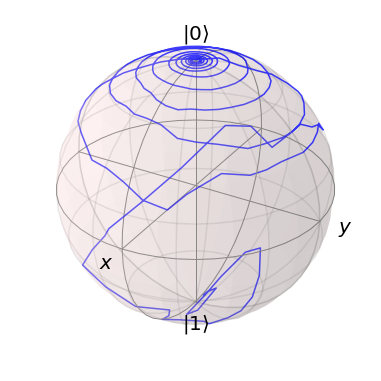

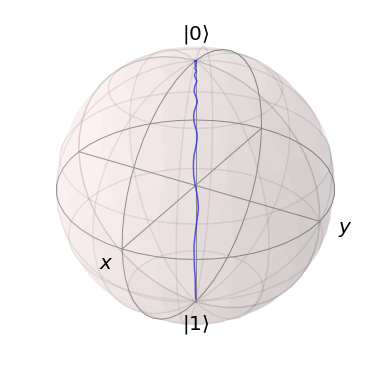

In [8]:
plt.ioff()
#plt.figure()
for tid in [0,1,2,3,'mean']:
    evh = expectations_vec_homodyne
    mvh = measurements_vec_homodyne
    evhx = evh['qubit_x']
    evhy = evh['qubit_y']
    evhz = evh['qubit_z']
    evhxiq = np.real(evhx)-np.imag(evhy) #if rwa else np.real(evhx)
    evhyiq = np.imag(evhx)+np.real(evhy) #if rwa else -np.real(evhy)
    expectation_x = evhxiq[:,tid] if tid != 'mean' else np.mean(evhxiq, axis=1)
    expectation_y = evhyiq[:,tid] if tid != 'mean' else np.mean(evhyiq, axis=1)
    expectation_z = evhz[:,tid] if tid != 'mean' else np.mean(evhz, axis=1)

    Bloch = qutip.Bloch()
    #Bloch.add_points([expectations_vec_homodyne['qubit_x'][:,2], 
    #                     expectations_vec_homodyne['qubit_y'][:,2], 
    #                     -2*expectations_vec_homodyne['qubit_z'][:,2]+1], meth='l')
    #Bloch.add_points([expectations_vec_homodyne['qubit_x'][:,1], 
    #                     expectations_vec_homodyne['qubit_y'][:,1], 
    #                     -2*expectations_vec_homodyne['qubit_z'][:,1]+1], meth='l')
    Bloch.add_points([expectation_x, 
                         expectation_y, 
                         -2*expectation_z+1], meth='l')
    Bloch.show()
    Bloch.fig.savefig('Decay demonstration homodyne Bloch trajectory {} {}.png'.format(tid, 'rwa' if rwa else 'non-rwa'))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


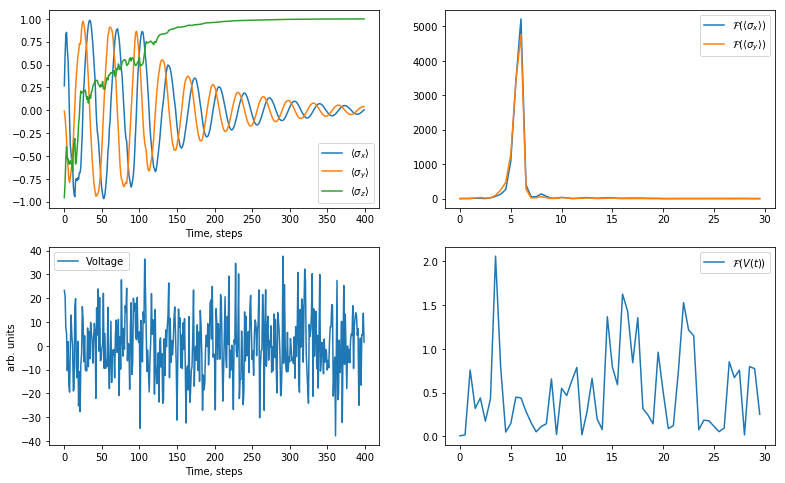

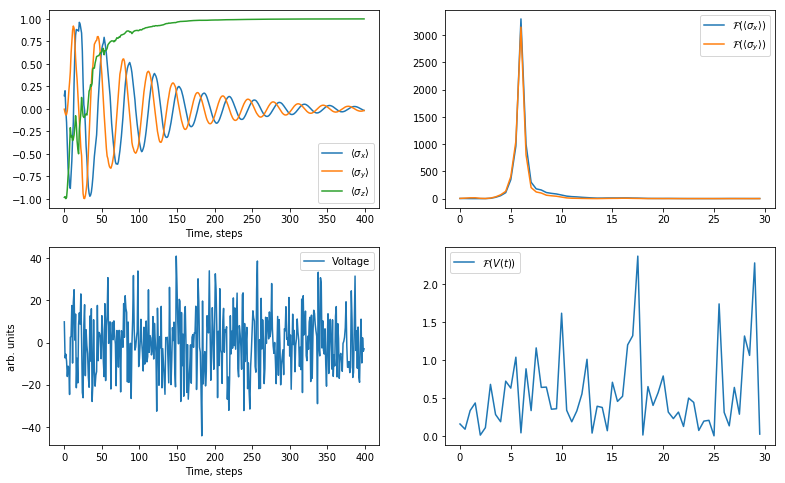

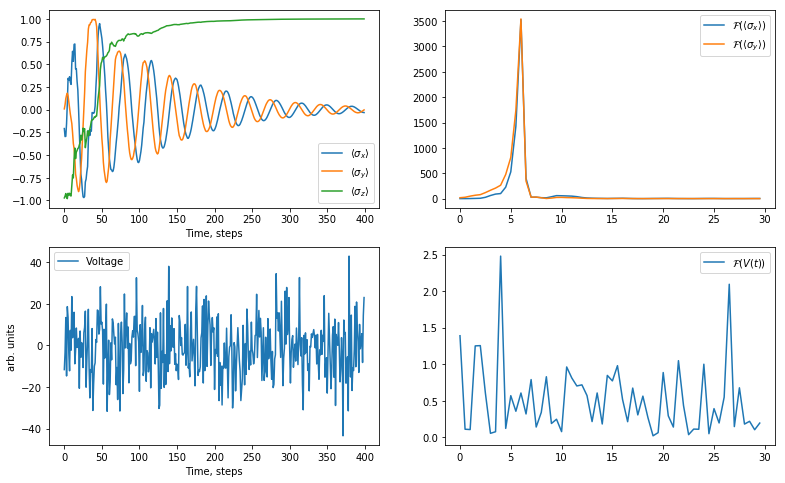

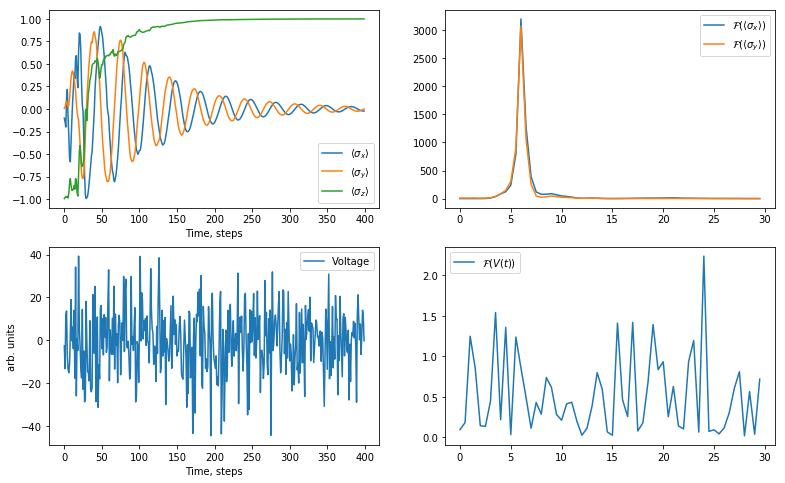

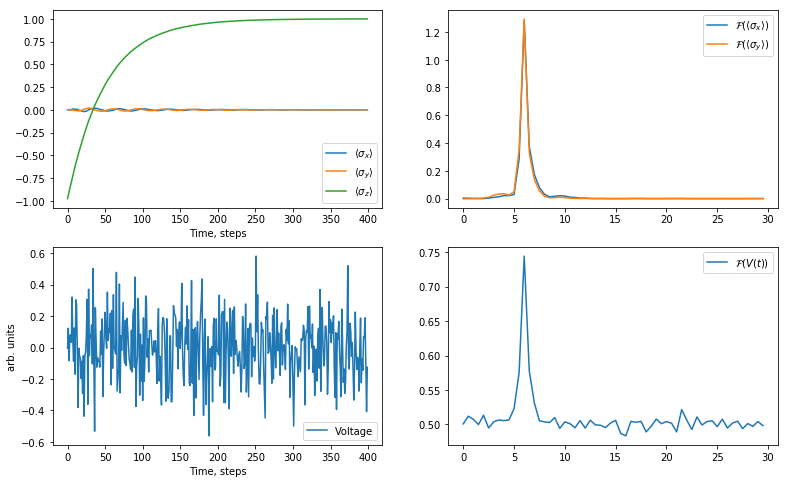

In [9]:
for tid in [0,1,2,3,'mean']:
    #plt.figure()
    figs, axes = plt.subplots(2,2, figsize=(13,8))
    color_cycle = plt.rcParams['axes.color_cycle']
    evh = expectations_vec_homodyne
    mvh = measurements_vec_homodyne
    evhx = evh['qubit_x']
    evhy = evh['qubit_y']
    evhz = evh['qubit_z']
    evhxiq = np.real(evhx)-np.imag(evhy) if rwa else evhx
    evhyiq = np.imag(evhx)+np.real(evhy) if rwa else evhy
    expectation_x = evhxiq[:,tid] if tid != 'mean' else np.mean(evhxiq, axis=1)
    expectation_y = evhyiq[:,tid] if tid != 'mean' else np.mean(evhyiq, axis=1)
    expectation_z = evhz[:,tid] if tid != 'mean' else np.mean(evhz, axis=1)
    measurement = mvh['qubit_decay'][:,tid] if tid != 'mean' else np.mean(mvh['qubit_decay'], axis=1)
    if tid != 'mean':
        measurement_ft = np.fft.fftshift(np.abs(np.fft.ifft(mvh['qubit_decay'][:,tid], axis=0))**2)
    else:
        measurement_ft = np.fft.fftshift(np.mean(np.abs(np.fft.ifft(mvh['qubit_decay'], axis=0))**2, axis=1))
    expectation_x_ft = np.fft.fftshift(np.abs((np.fft.fft(expectation_x))**2))
    expectation_y_ft = np.fft.fftshift(np.abs((np.fft.fft(expectation_y))**2))
    freqs = np.fft.fftshift(np.fft.fftfreq(n=len(expectation_x_ft), d=1./qed.decoherences['qubit_decay']['sample_rate']))

    expectation_x_ft = expectation_x_ft[np.logical_and(freqs>=0, freqs<30)]
    expectation_y_ft = expectation_y_ft[np.logical_and(freqs>=0, freqs<30)]
    measurement_ft = measurement_ft[np.logical_and(freqs>=0, freqs<30)]
    freqs = freqs[np.logical_and(freqs>=0, freqs<30)]

    axes[0,0].plot(expectation_x, color=color_cycle[0], label='$\\langle \\sigma_x \\rangle$')
    axes[0,0].plot(expectation_y, color=color_cycle[1], label='$\\langle \\sigma_y \\rangle$')
    axes[0,0].plot(-2*expectation_z+1, color=color_cycle[2], label='$\\langle \\sigma_z  \\rangle$')

    axes[1,0].plot(measurement, label='Voltage')
    axes[0,0].legend()
    axes[1,0].legend()
    axes[0,0].set_xlabel('Time, steps')
    axes[1,0].set_xlabel('Time, steps')
    axes[1,0].set_ylabel('arb. units')

    axes[0,1].plot(freqs, expectation_x_ft, label='$\\mathcal{F}\\left(\\langle \\sigma_x \\rangle\\right)$')
    axes[0,1].plot(freqs, expectation_y_ft, label='$\\mathcal{F}\\left(\\langle \\sigma_y \\rangle\\right)$')
    axes[0,1].legend()

    axes[1,1].plot(freqs, measurement_ft, label='$\\mathcal{F}\\left(V(t)\\right)$')
    axes[1,1].legend()

    plt.savefig('Decay demonstration homodyne trajectory {} {}.png'.format(tid, 'rwa' if rwa else 'non-rwa'))
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


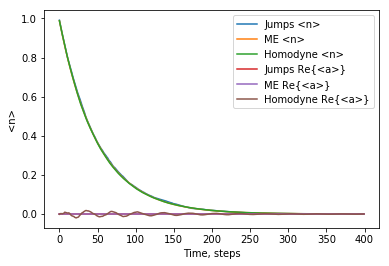

In [10]:
from matplotlib.pyplot import plot as plot
from matplotlib.pyplot import legend as legend
#print (expectations_vec['qubit_z'])
plot(np.mean(expectations_vec['qubit_z'], axis=1).T, label='Jumps <n>')
plot(np.mean(expectations_mat['qubit_z'], axis=1).T, label='ME <n>')
plot(np.mean(expectations_vec_homodyne['qubit_z'], axis=1).T, label='Homodyne <n>')
plot(np.mean(expectations_vec['qubit_x'], axis=1).T, label='Jumps Re{<a>}')
plot(np.mean(expectations_mat['qubit_x'], axis=1).T, label='ME Re{<a>}')
plot(np.mean(expectations_vec_homodyne['qubit_x'], axis=1).T, label='Homodyne Re{<a>}')
plt.legend()
plt.xlabel('Time, steps')
plt.ylabel('<n>')
plt.savefig('Decay demonstration average.png')
plt.show()
